# Evaluation of variability of diffusion model training and sampling for 60km -> 2.2km-4x over Birmingham

Compare different model runs based on inputs:

* PslTV

For each version: inputs are standardized; target is sqrt, divided by max to put on [0,1] then recentred to [-1,1]

NO PIXELMMS

## Diff model

8-channels loc-spec params

Inputs: all at 5 levels

Target domain and resolution: 64x64 2.2km-4x England and Wales

Input resolution: 60km/gcmx

Input transforms are fitted on dataset in use (ie separate GCM and CPM versions) while target transform is fitted only at training on the CPM dataset

In [ ]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pysteps
import xarray as xr

from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, plot_grid, prep_eval_data, show_samples, distribution_figure, plot_mean_bias, plot_std_bias, plot_psd

Pysteps configuration file found at: /user/home/vf20964/miniconda3/envs/downscaling-notebooks/lib/python3.9/site-packages/pysteps/pystepsrc



In [ ]:
def load_data(samples_configs):
    xr_datasets = []
    for samples_config in samples_configs:
        split = samples_config["split"]
        data_config = samples_config["data_config"]
        merged_ds = xr.merge([ prep_eval_data(c["datasets"], c["runs"], split) for c in data_config ])

        print(merged_ds.dims)
        print(merged_ds.coords)
        print(merged_ds.data_vars)
        xr_datasets.append(merged_ds)
    return xr_datasets

In [ ]:
samples_configs = [
    dict(
        split = "val",
        data_config = [
            dict(
                datasets = {
                    "CPM": "bham_gcmx-4x_psl-temp-vort_random",
                    "GCM": "bham_60km-4x_psl-temp-vort_random",
                },
                runs = [
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen", "epoch-100", "100 epochs 100% val Run 1"),
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen-2", "epoch-100", "100 epochs 100% val Run 2"),
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen-3", "epoch-100", "100 epochs 100% val Run 3"),
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen-4", "epoch-100", "100 epochs 100% val Run 4"),
                ]
            ),
        ],
    ),
    dict(
        split = "val",
        data_config = [
            dict(
                datasets = {
                    "CPM": "bham_gcmx-4x_psl-temp-vort_random",
                    "GCM": "bham_60km-4x_psl-temp-vort_random",
                },
                runs = [
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen", "epoch-75", "75 epochs 100% val Run 1"),
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen-2", "epoch-75", "75 epochs 100% val Run 2"),
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen-3", "epoch-75", "75 epochs 100% val Run 3"),
                ]
            ),
        ],
    ),
    dict(
        split = "val",
        data_config = [
            dict(
                datasets = {
                    "CPM": "bham_gcmx-4x_psl-temp-vort_random",
                    "GCM": "bham_60km-4x_psl-temp-vort_random",
                },
                runs = [
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen", "epoch-50", "50 epochs 100% val Run 1"),
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen-2", "epoch-50", "50 epochs 100% val Run 2"),
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen-3", "epoch-50", "50 epochs 100% val Run 3"),
                ]
            ),
        ],
    ),
    dict(
        split = "val-50pc",
        data_config = [
            dict(
                datasets = {
                    "CPM": "bham_gcmx-4x_psl-temp-vort_random",
                    "GCM": "bham_60km-4x_psl-temp-vort_random",
                },
                runs = [
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen", "epoch-100", "100 epochs 50% val Run 1"),
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen-2", "epoch-100", "100 epochs 50% val Run 2"),
                    ("score-sde/subvpsde/xarray_cncsnpp_continuous/bham-4x_PslTV_random-IstanTsqrturrecen-3", "epoch-100", "100 epochs 50% val Run 3"),
                ]
            ),
        ],
    ),
]

xr_datasets = load_data(samples_configs)

quantiles = np.concatenate([np.linspace((1-10**(i+1))+(10**i), (1-10**i), 9) for i in range(-1, -8, -1)])

Frozen({'time': 4320, 'grid_latitude': 64, 'grid_longitude': 64, 'model': 4, 'source': 2, 'sample_id': 3, 'bnds': 2})
Coordinates:
  * time            (time) object 1980-12-03 12:00:00 ... 2080-11-20 12:00:00
  * grid_latitude   (grid_latitude) float32 -2.49 -2.41 -2.33 ... 2.39 2.47 2.55
  * grid_longitude  (grid_longitude) float32 357.9 358.0 358.1 ... 362.9 363.0
  * model           (model) object '100 epochs 100% val Run 1' ... '100 epoch...
    season          (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * source          (source) object 'CPM' 'GCM'
Data variables:
    rotated_latitude_longitude  (source, model, sample_id, time) float64 -2.1...
    time_bnds                   (source, model, sample_id, time, bnds) object ...
    grid_latitude_bnds          (source, model, sample_id, time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (source, model, sample_id, time, grid_longitude, bnds) float32 ...
    pred_pr                     (source, mode

# CPM distributions

CPM

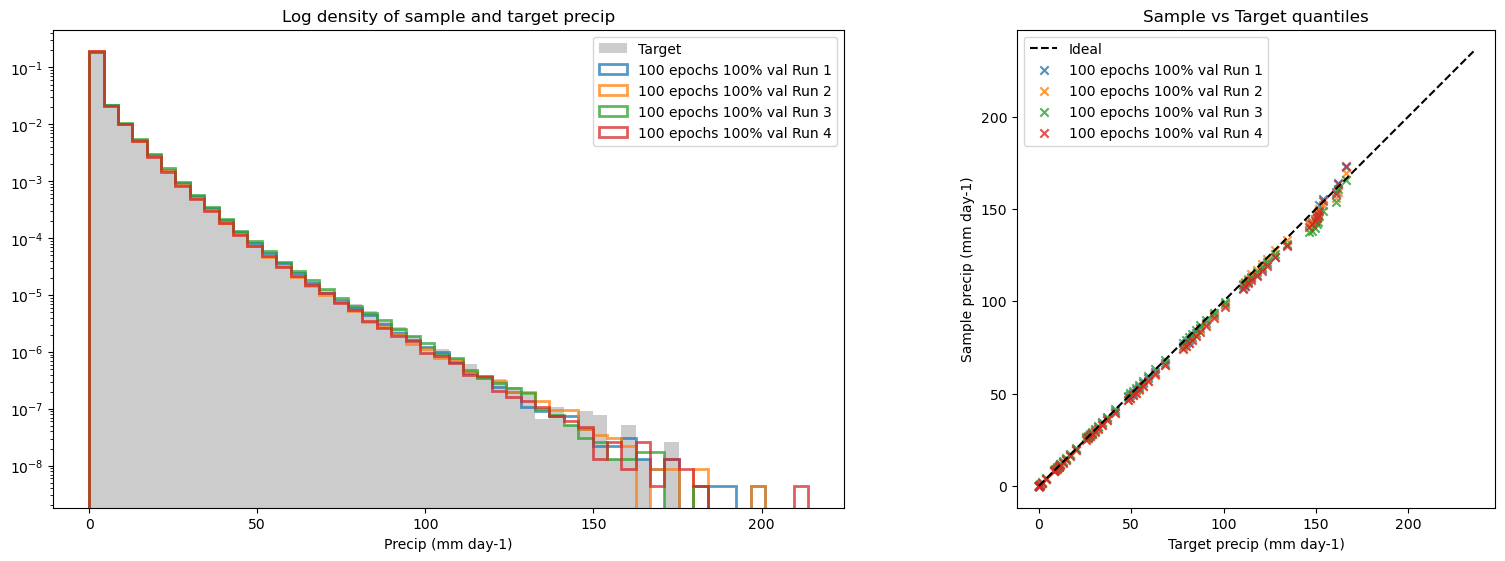

CPM

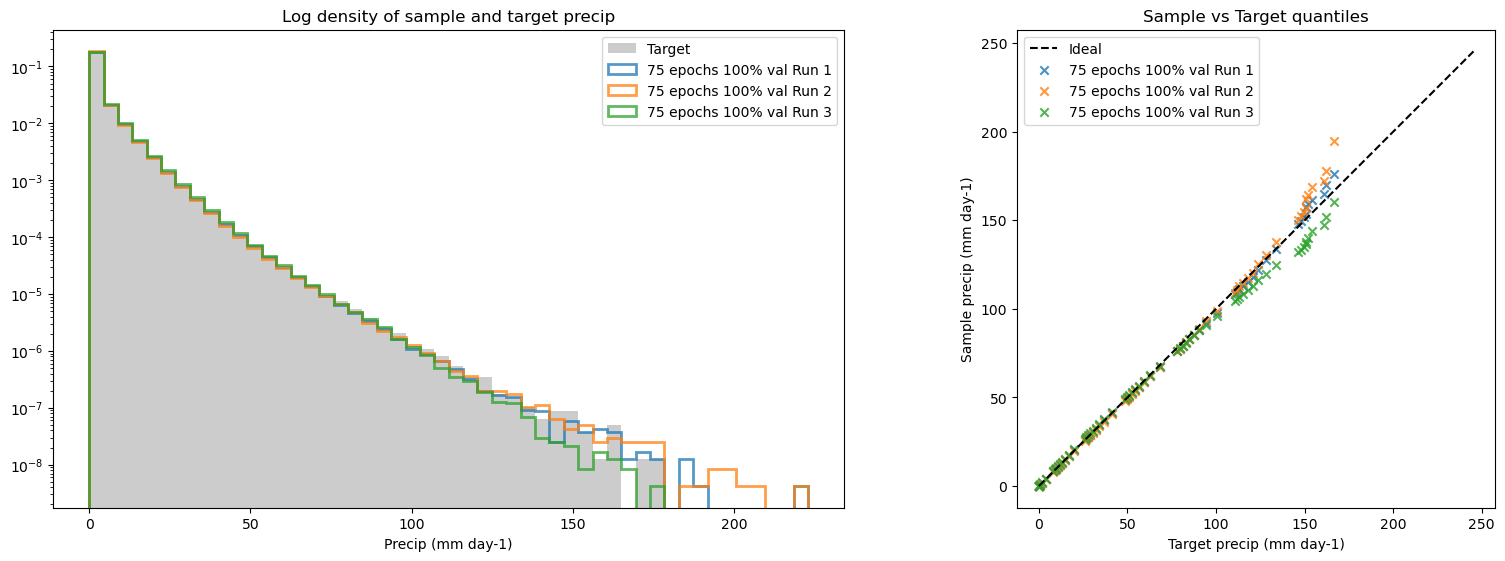

CPM

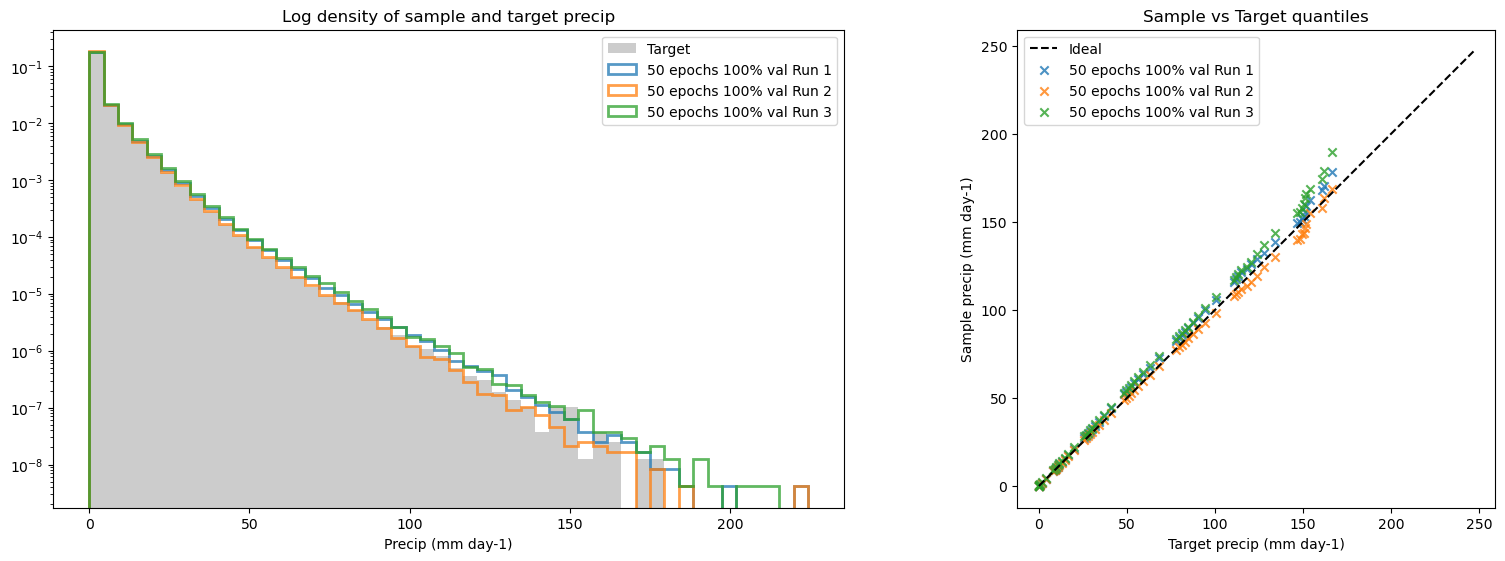

CPM

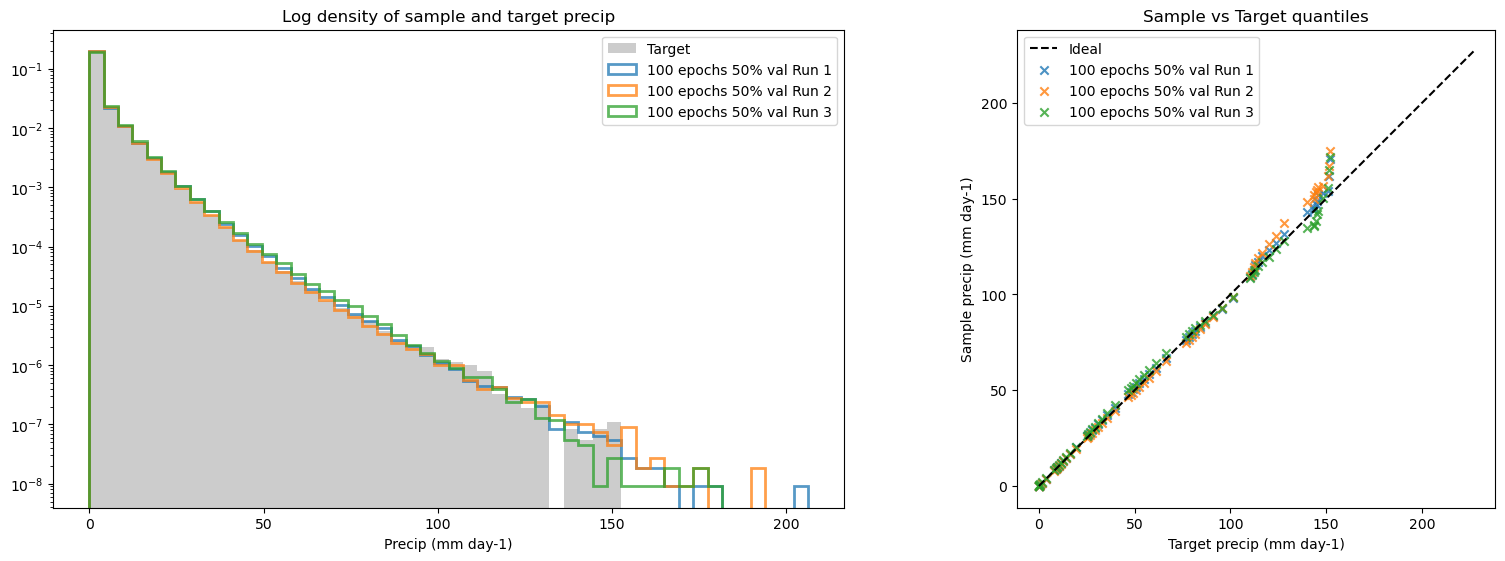

In [ ]:
for merged_ds in xr_datasets:
    target_pr = merged_ds.sel(source="CPM")["target_pr"]
    distribution_figure(merged_ds.sel(source=["CPM"]), target_pr, quantiles, "Distribution of pixel values")

# GCM distributions

GCM

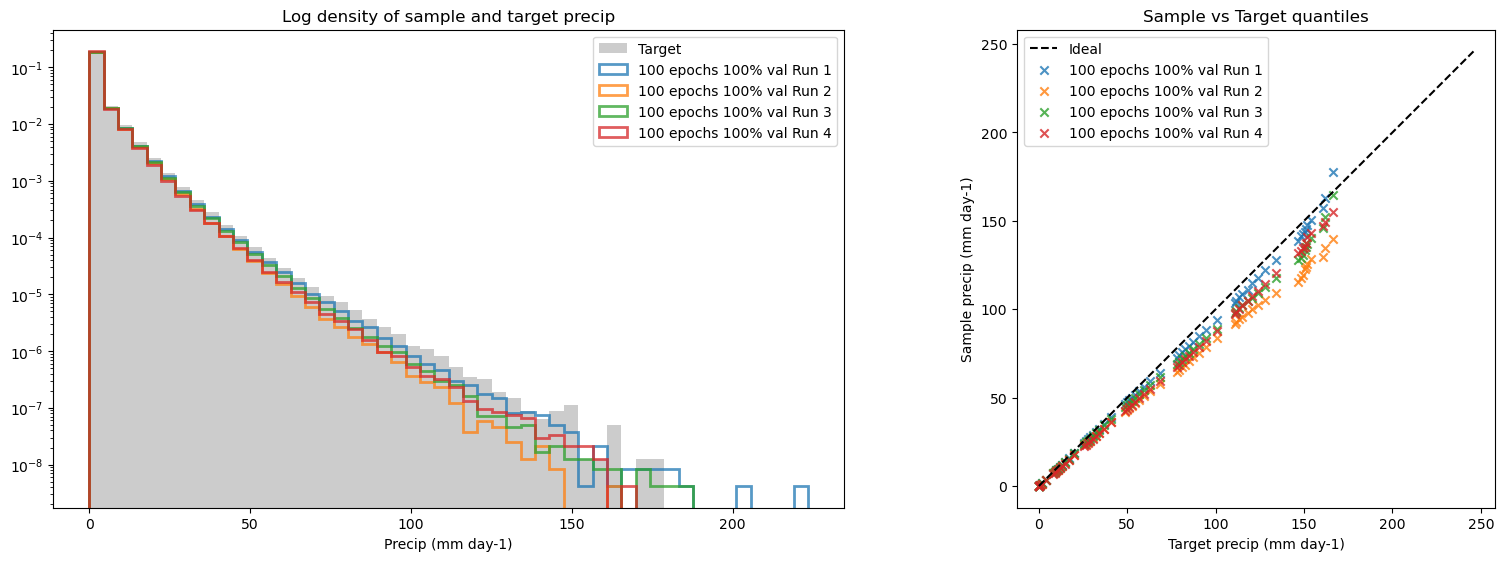

GCM

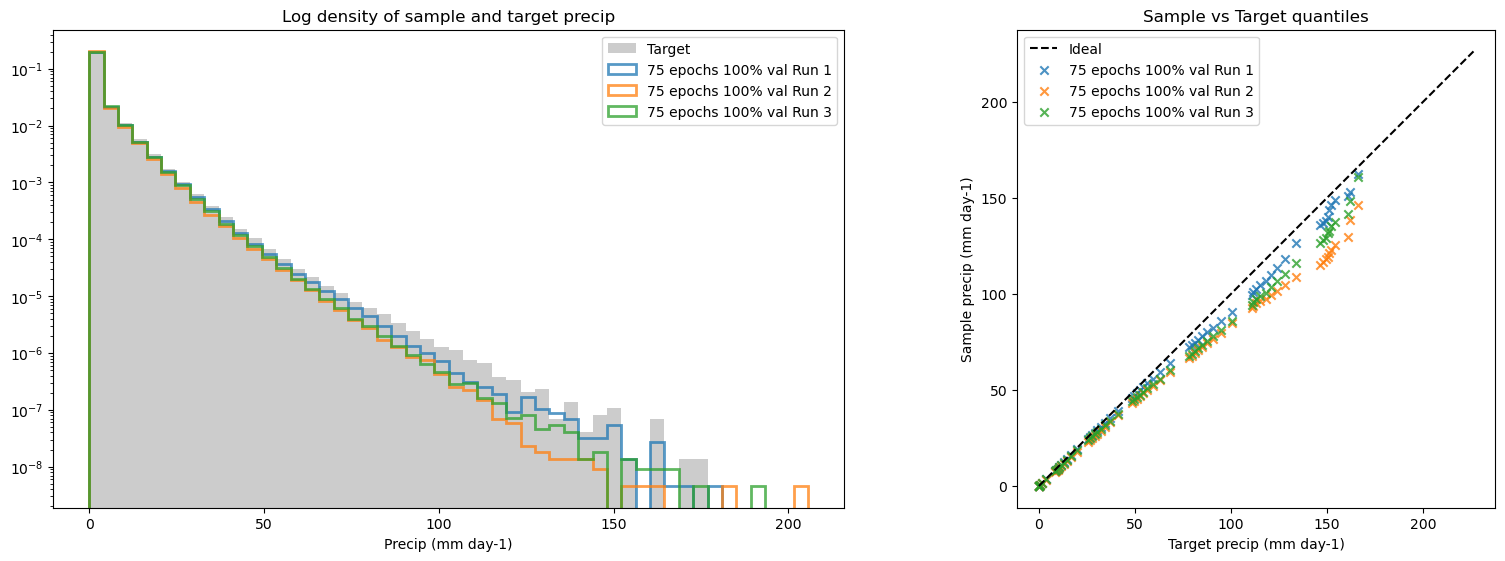

GCM

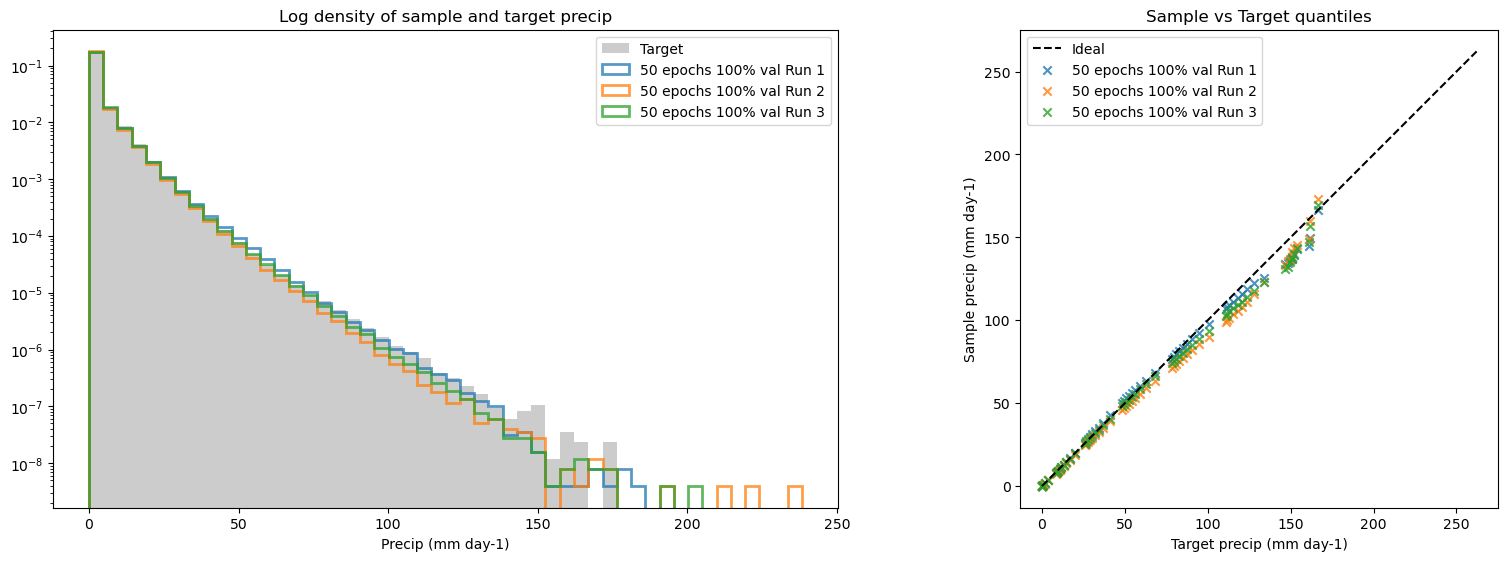

GCM

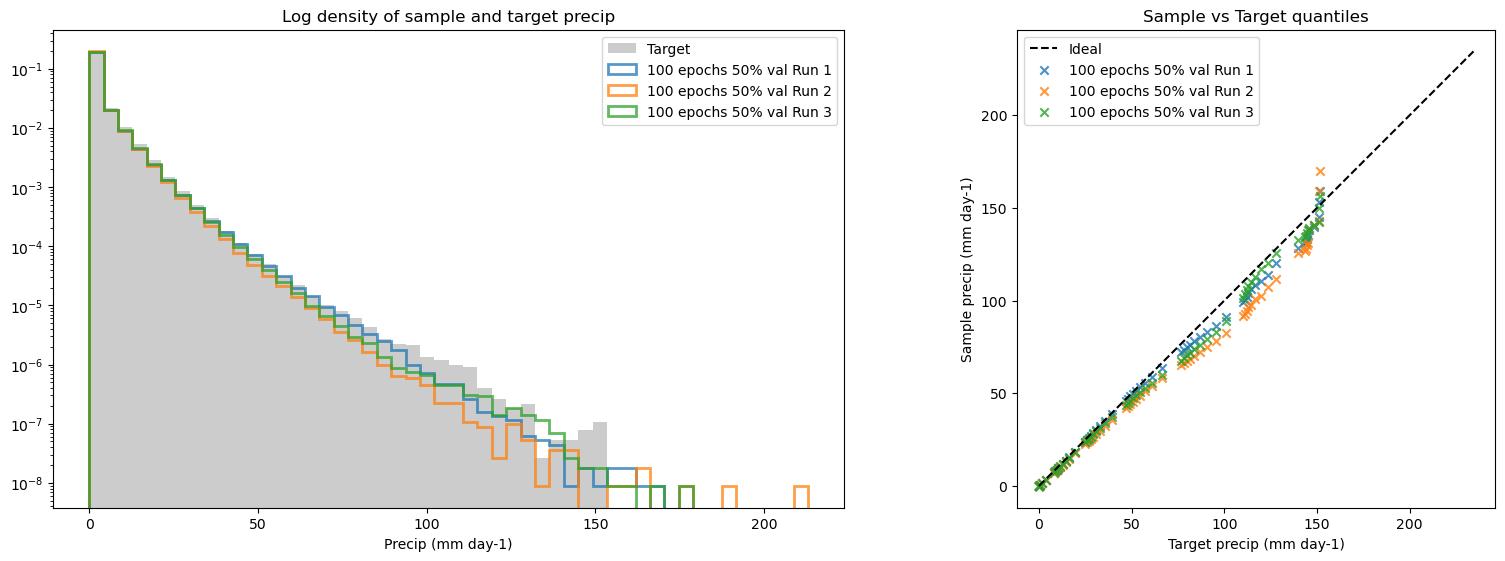

In [ ]:
for merged_ds in xr_datasets:
    target_pr = merged_ds.sel(source="CPM")["target_pr"]
    distribution_figure(merged_ds.sel(source=["GCM"]), target_pr, quantiles, "Distribution of pixel values")

# Mean bias

CPM

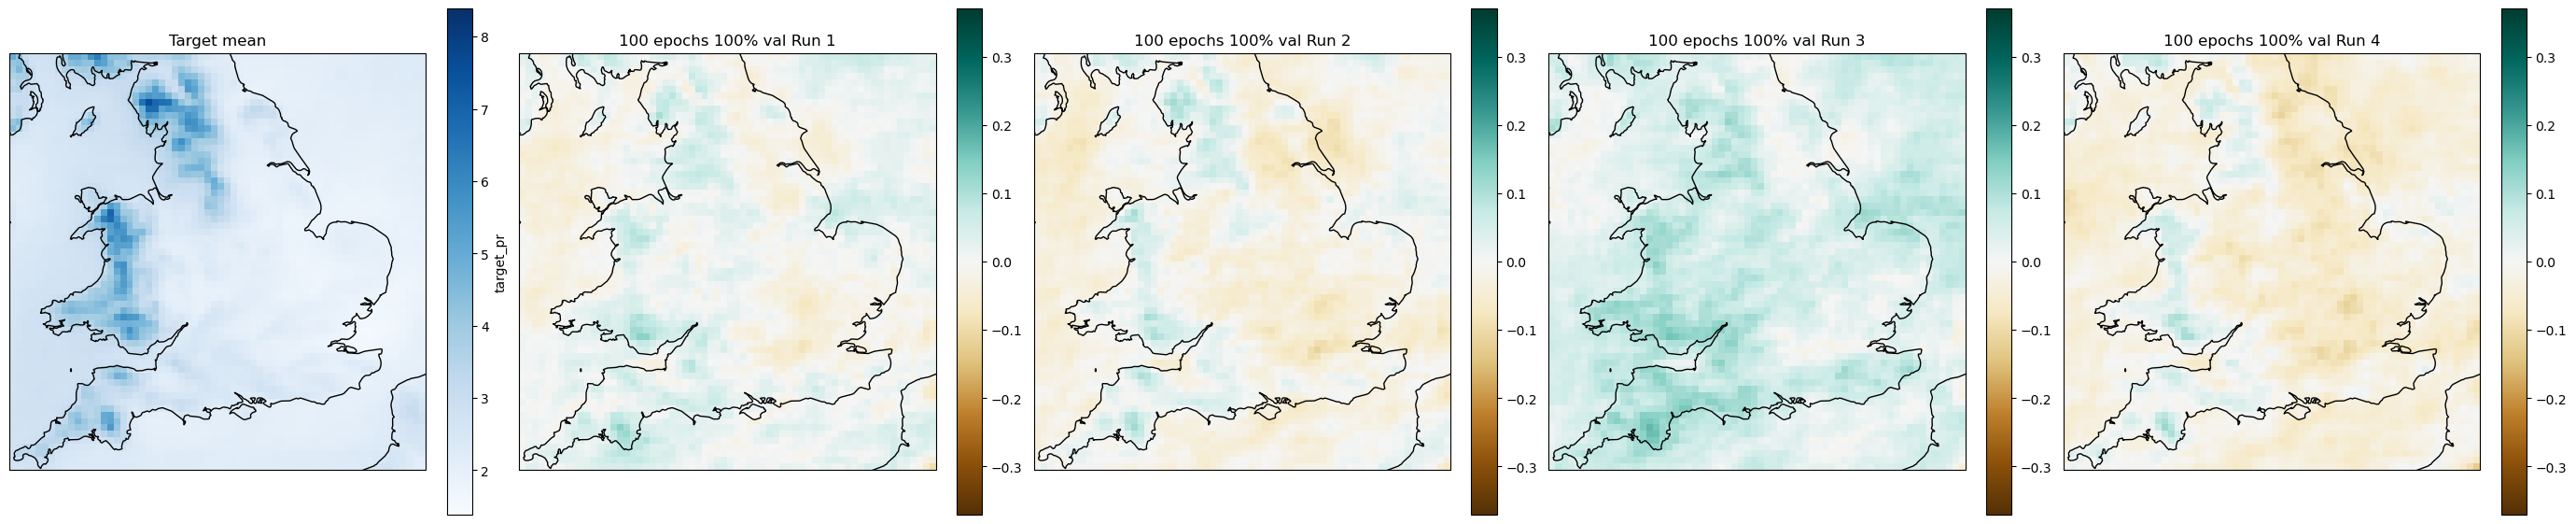

GCM

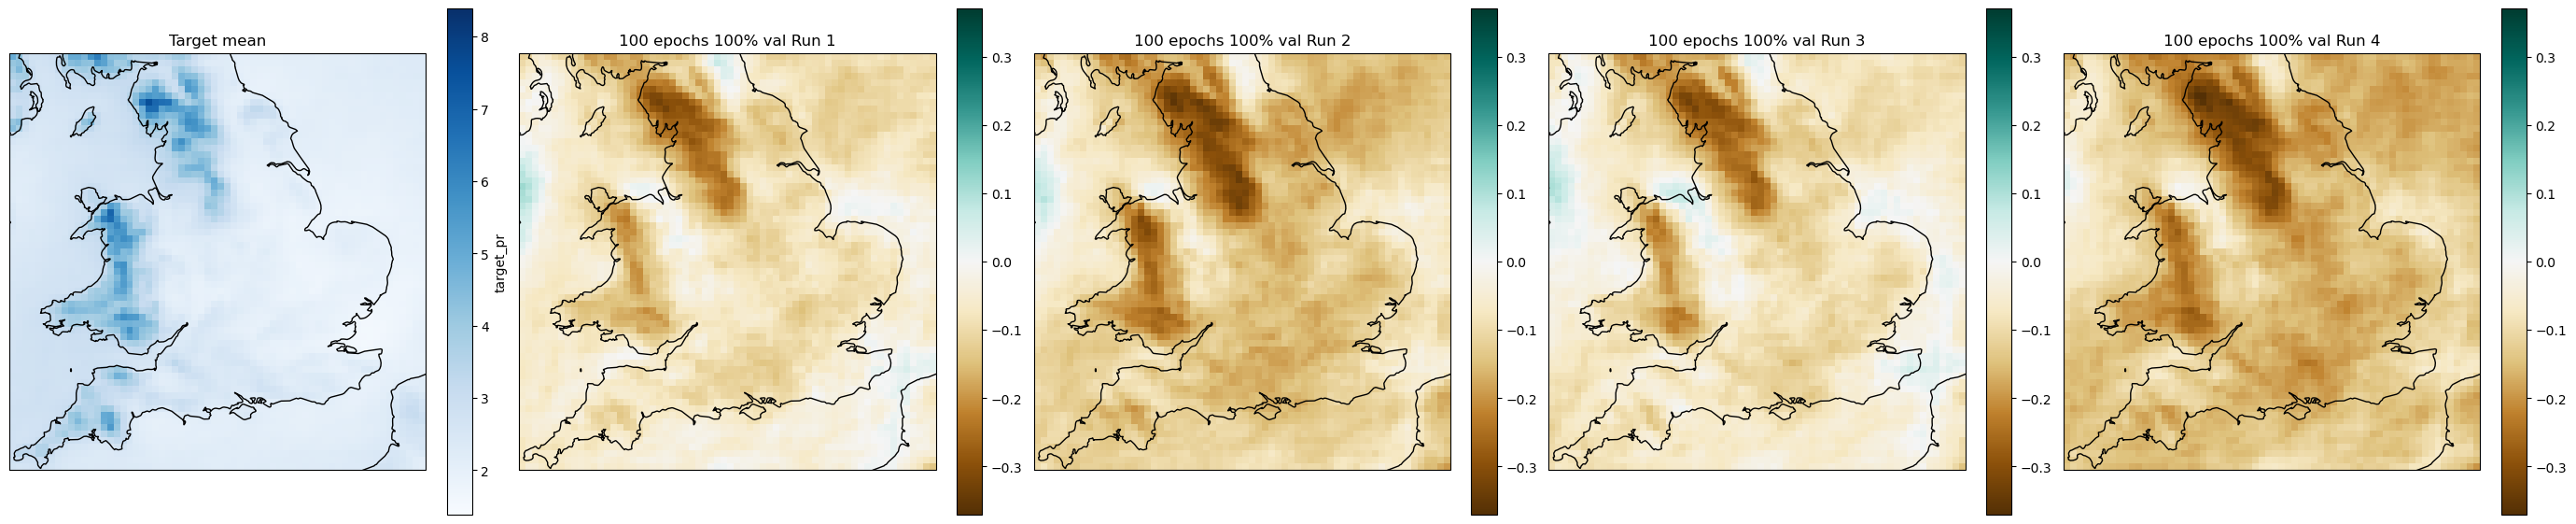

CPM

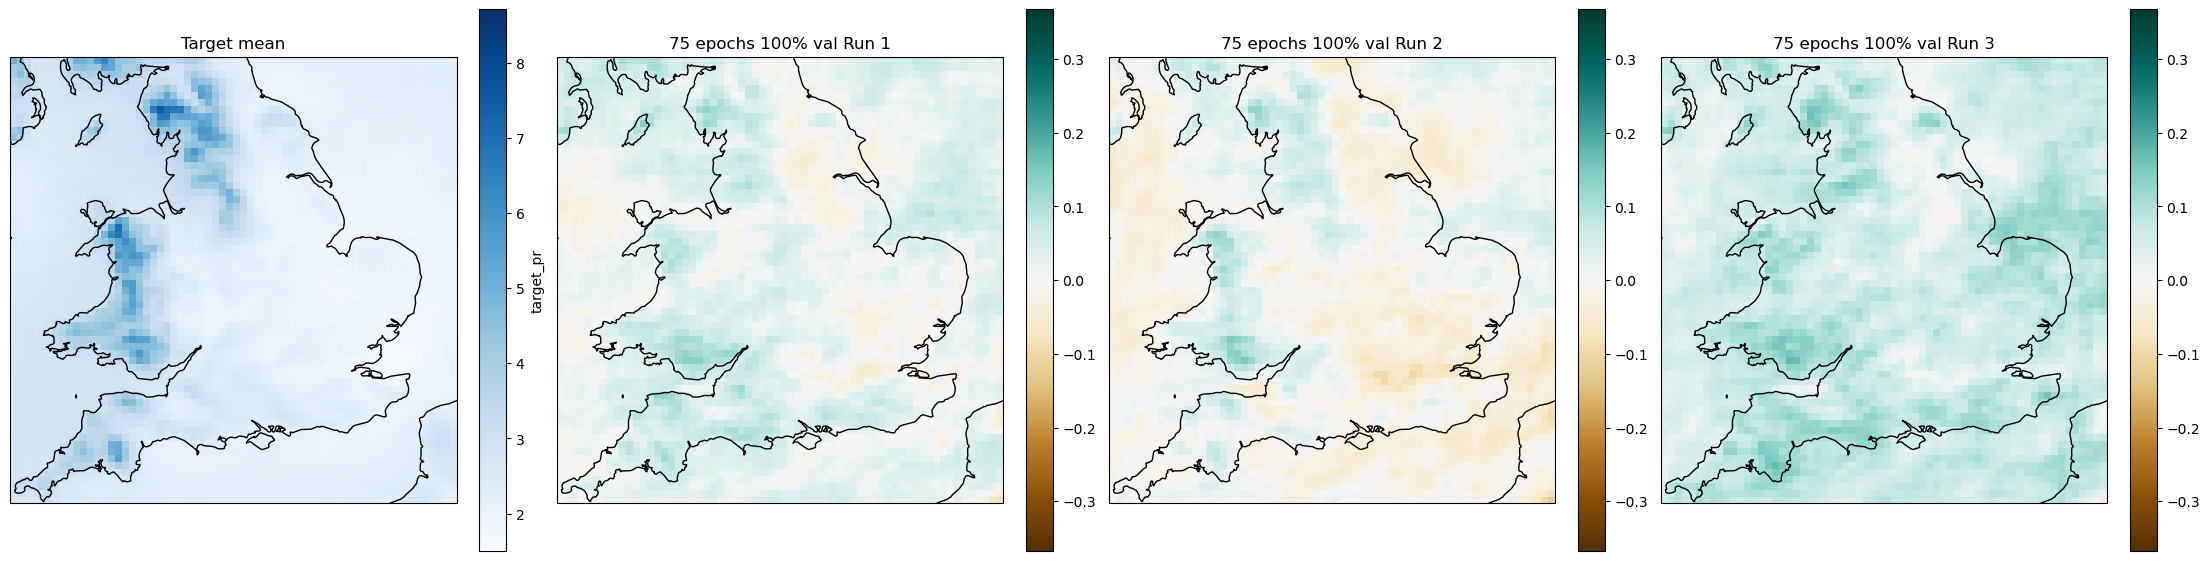

GCM

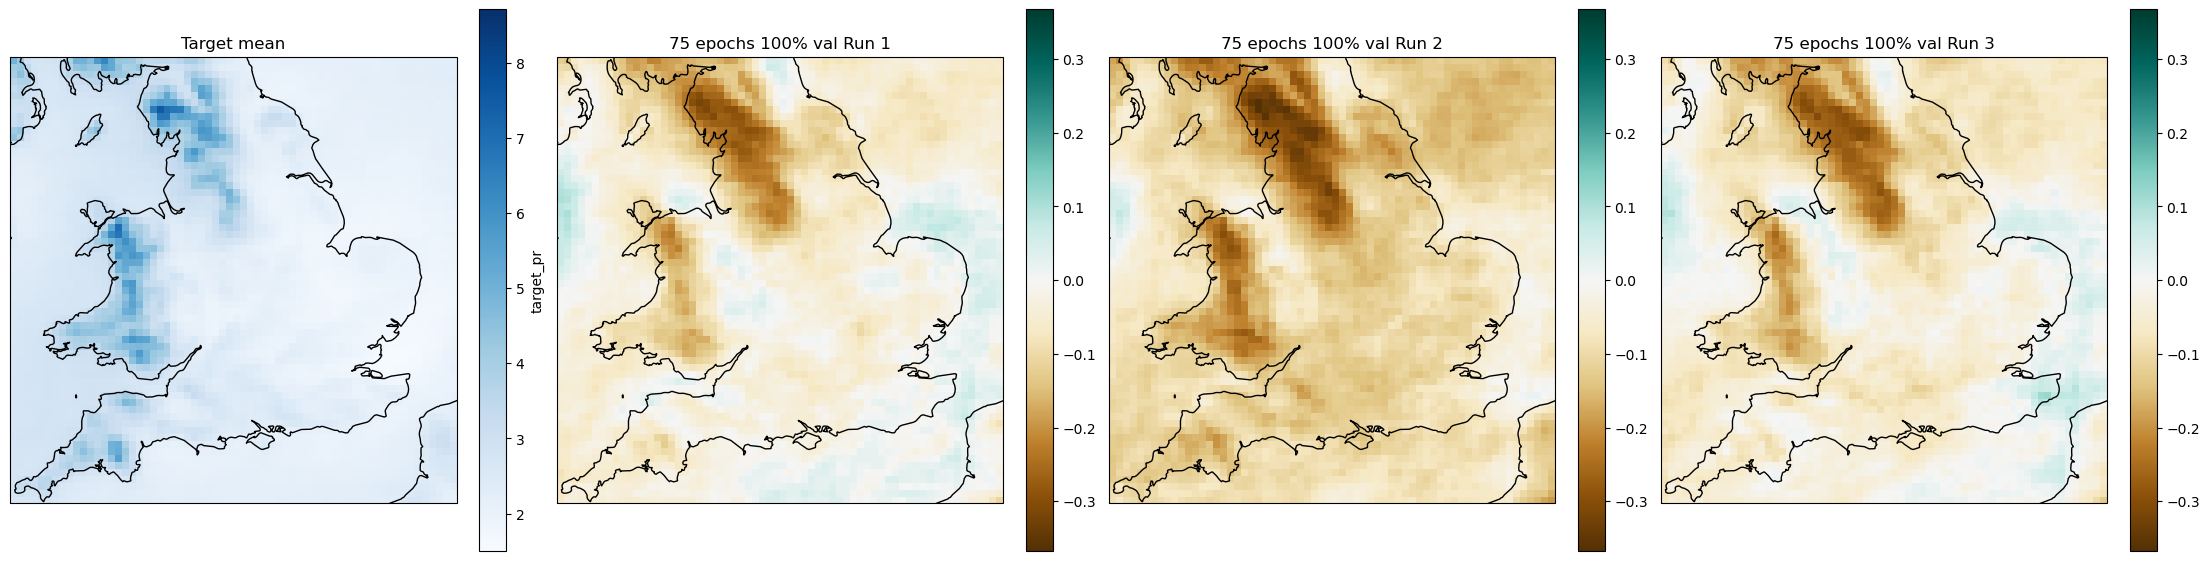

CPM

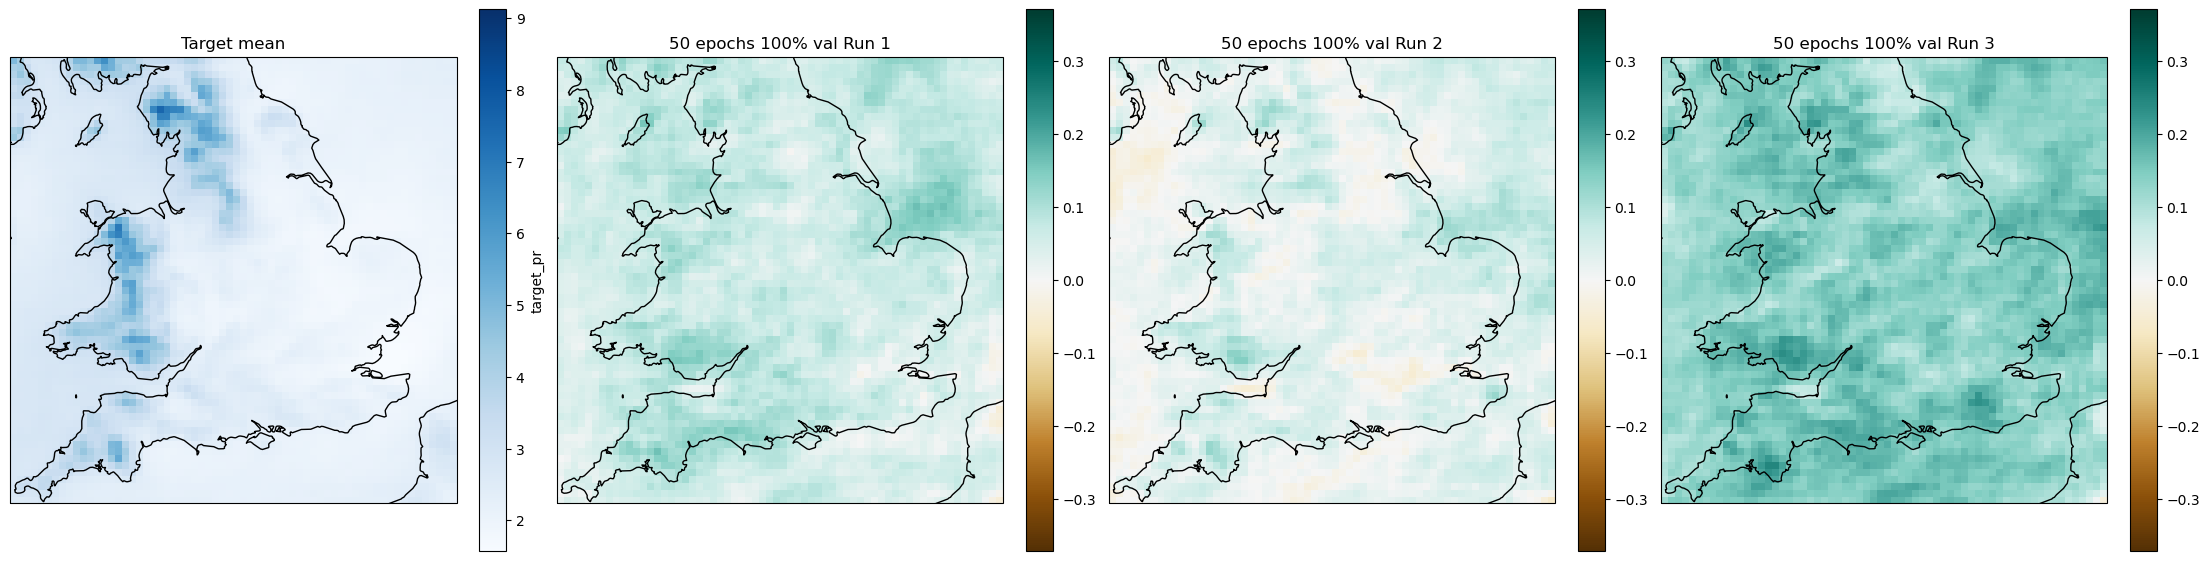

GCM

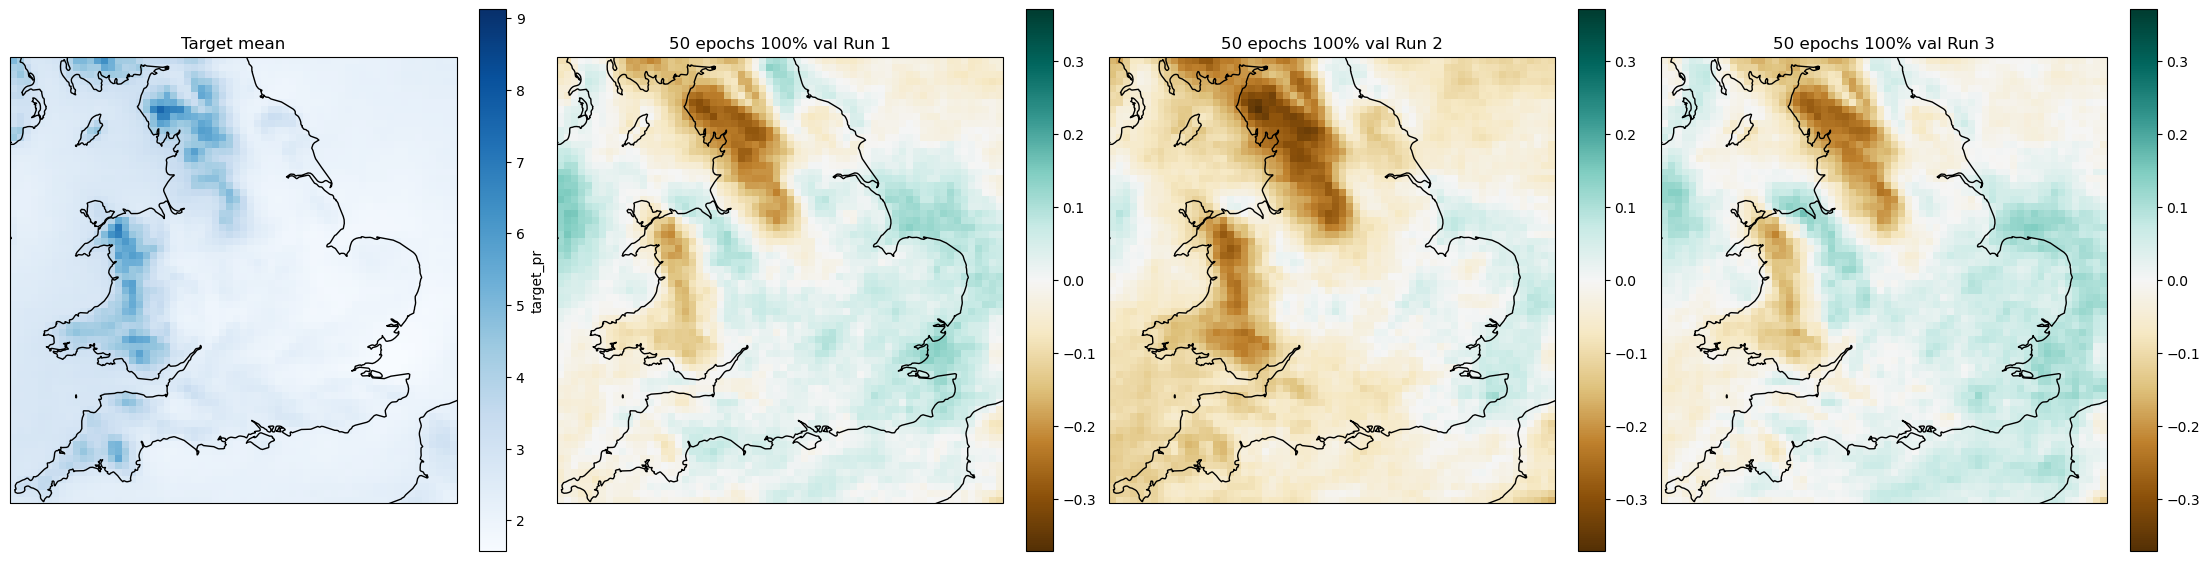

CPM

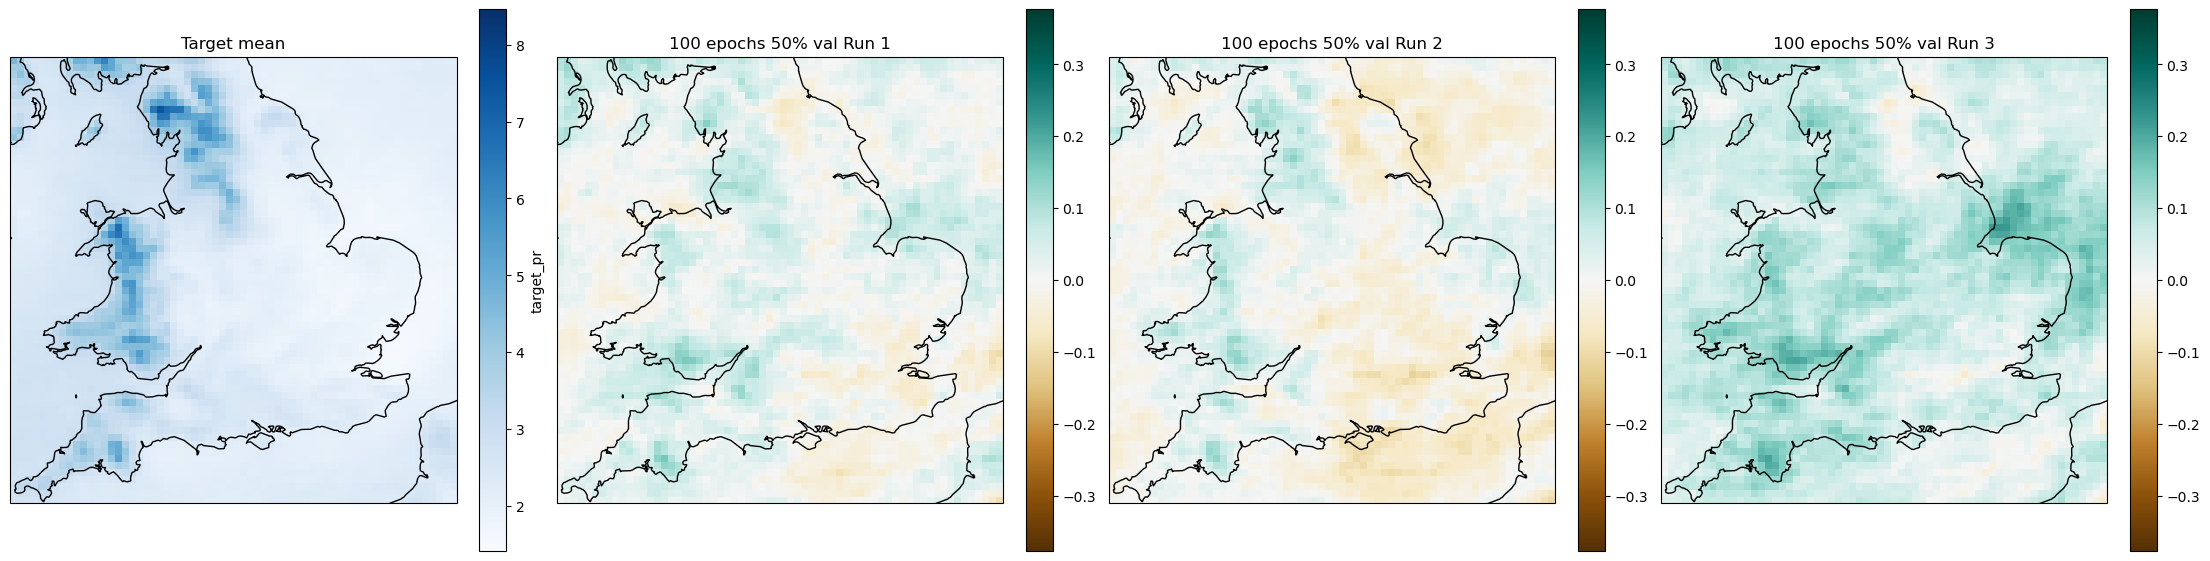

GCM

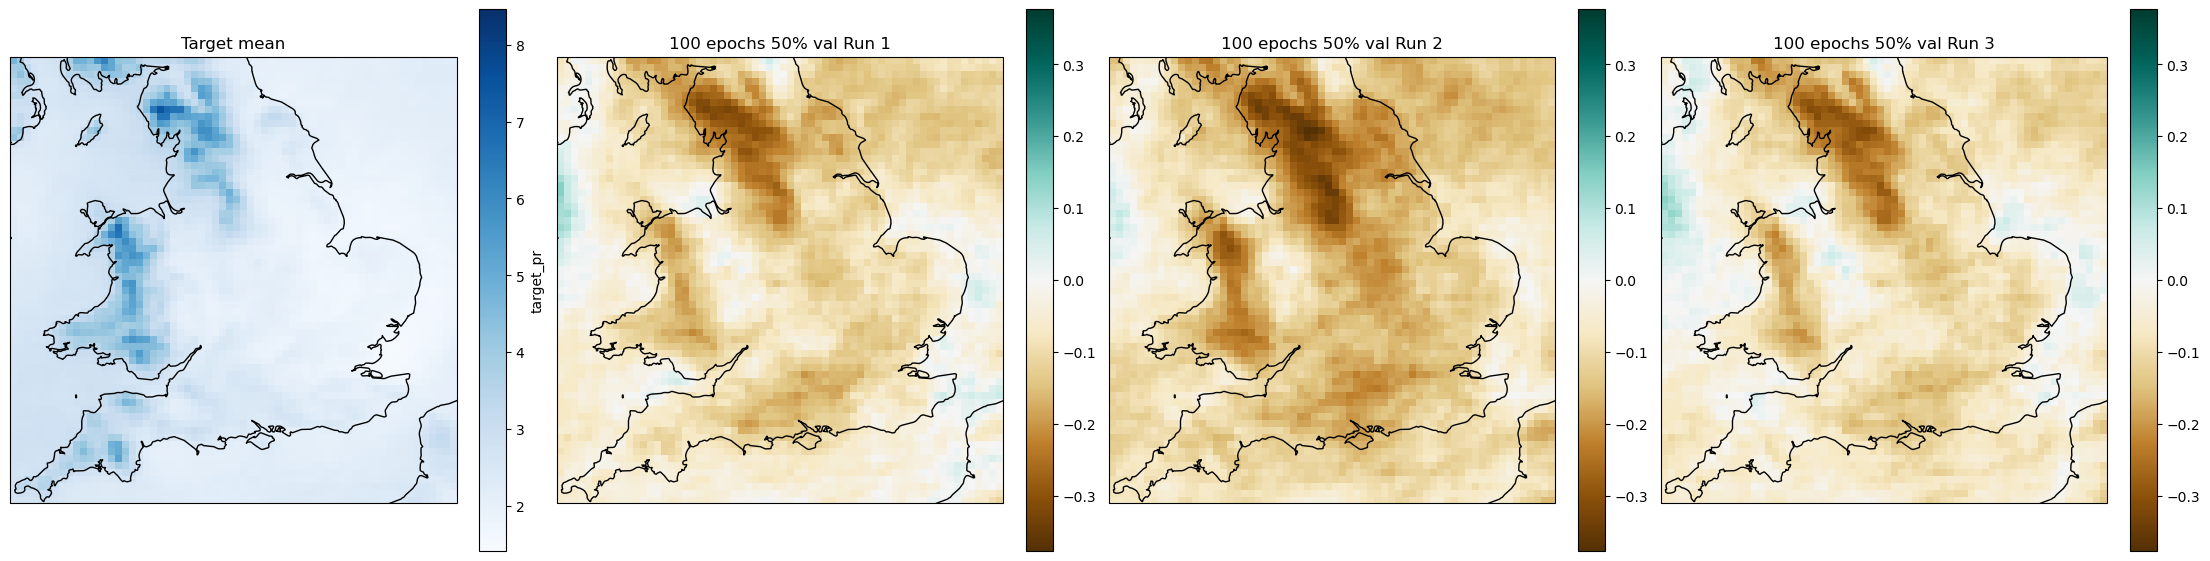

In [ ]:
for merged_ds in xr_datasets:
    target_pr = merged_ds.sel(source="CPM")["target_pr"]
    plot_mean_bias(merged_ds, target_pr)